# RihkyeTaskBatch dataset & Elman RNN model

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import sys, shelve

import torch
import torch.nn as nn
import torch.nn.functional as F


sys.path.append('..')
from task import RikhyeTaskBatch

## Dataset

In [22]:
RNGSEED = 5
np.random.seed([RNGSEED])

num_cueingcontext = 2
num_cue = 2
num_rule = 2
rule = [0, 1, 0, 1]
blocklen = [500, 500, 200]
block_cueingcontext = [0, 1, 0]
tsteps = 200
cuesteps = 100
batch_size = 1

dataset = RikhyeTaskBatch(num_cueingcontext=num_cueingcontext, num_cue=num_cue, num_rule=num_rule, rule=rule, blocklen=blocklen, \
block_cueingcontext=block_cueingcontext, tsteps=tsteps, cuesteps=cuesteps, batch_size=batch_size)

#input, target = dataset()
#print(input.shape, target.shape, '\n')
#print(input[210:220, 9, :])
#print(target[210:220, 9, :])

## Model

In [23]:
class Elman(nn.Module):
    """Use pytorch RNN to create a model
    Parameters:
    input_size: int, RNN input size
    hidden_size: int, RNN hidden size
    output_size: int, output layer size
    num_layers: int, number of RNN layers
    nonlinearity: str, 'tanh' or 'relu', nonlinearity in RNN layers
    """

    def __init__(self, input_size, hidden_size, output_size, num_layers, nonlinearity='tanh'):
        super().__init__()

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, nonlinearity=nonlinearity)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out

## Training

In [24]:
import time

# Model settings
input_size = 4 # 4 cues
hidden_size = 200
output_size = 2 # 2 rules
num_layers = 1
losses = []
timestamps = []

model = Elman(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers, nonlinearity='relu')

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


total_step = sum(blocklen)//batch_size
print_step = 10
running_loss = 0.0
running_train_time = 0
model_name = 'model-' + str(int(time.time()))
savemodel = False


for i in range(total_step):

    train_time_start = time.time()

    inputs, labels = dataset()

    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels).type(torch.float)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)

    loss = criterion(outputs, labels)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()


    # print statistics
    running_loss += loss.item()
    running_train_time += time.time() - train_time_start

    if i % print_step == (print_step - 1):

        print('Total step: {:d}'.format(total_step))
        print('Training sample index: {:d}-{:d}'.format(i+1-print_step, i+1))

        # running loss
        print('loss: {:0.5f}'.format(running_loss / print_step))
        losses.append(running_loss / print_step)
        timestamps.append(i+1-print_step)
        running_loss = 0.0

        # training time
        print('Predicted left training time: {:0.0f} s'.format(
             (running_train_time) * (total_step - i - 1) / print_step), '\n')
        running_train_time = 0

        if savemodel:
            # save model every print_step
            fname = os.path.join('models', model_name + '.pt')
            torch.save(model.state_dict(), fname)

            # save info of the model
            fpath = os.path.join('models', model_name + '.txt')
            with open(fpath, 'w') as f:
                f.write('input_size = ' + str(input_size) + '\n')
                f.write('hidden_size = ' + str(hidden_size) + '\n')
                f.write('output_size = ' + str(output_size) + '\n')
                f.write('num_layers = ' + str(num_layers) + '\n')


print('Finished Training')

Total step: 1200
Training sample index: 0-10
loss: 0.38347
Predicted left training time: 72 s 

Total step: 1200
Training sample index: 10-20
loss: 0.21196
Predicted left training time: 62 s 

Total step: 1200
Training sample index: 20-30
loss: 0.13999
Predicted left training time: 62 s 

Total step: 1200
Training sample index: 30-40
loss: 0.06892
Predicted left training time: 56 s 

Total step: 1200
Training sample index: 40-50
loss: 0.02396
Predicted left training time: 57 s 

Total step: 1200
Training sample index: 50-60
loss: 0.01372
Predicted left training time: 57 s 

Total step: 1200
Training sample index: 60-70
loss: 0.01068
Predicted left training time: 54 s 

Total step: 1200
Training sample index: 70-80
loss: 0.00831
Predicted left training time: 53 s 

Total step: 1200
Training sample index: 80-90
loss: 0.00671
Predicted left training time: 53 s 

Total step: 1200
Training sample index: 90-100
loss: 0.00585
Predicted left training time: 60 s 

Total step: 1200
Training samp

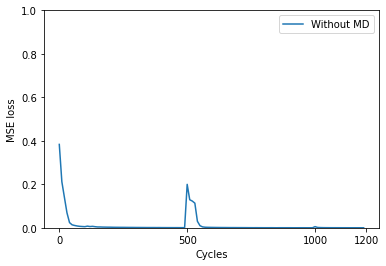

In [25]:
import matplotlib.pyplot as plt

plt.plot(timestamps, losses, label='Without MD')
plt.xlabel('Cycles')
plt.ylabel('MSE loss')
plt.legend()
plt.xticks([0, 500, 1000, 1200])
plt.ylim([0.0, 1.0])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()